In [1]:
# python
import os
from itertools import combinations_with_replacement, combinations, product

# stats
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.api import OLS
from pandas.api.types import CategoricalDtype

# plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns


# analysis code
from lib.functions_second_analysis import *
from lib.functions_scripting import *

beauty_ratings = load_ratings(PATH_RATINGS)

In [2]:
_models = MODEL_NAMES
_studies = STUDY_NAMES
_datasets = DATASET_NAMES
_scales = SCALE_NAMES

In [ ]:
_models = MODEL_NAMES
_studies = "short presentation"
_datasets = "places1"
_scales = "scale4"

In [3]:
_models = NETS_ALL
_studies = STUDY_NAMES
_datasets = DATASET_NAMES
_scales = SCALE_NAMES

In [3]:
# subselect models that have significant predictions at scale4
models_to_remove = set(
    [
        "edge_occlusion",
        "inpainting",
        "keypoints2d",
        "segment_unsup25d",
        "class_scene",
        "normal",
        "jigsaw",
    ]
)
_models = list(set(MODEL_NAMES).difference(models_to_remove))

In [3]:
# subselect models that have significant predictions at scale4
models_to_remove = set(
    [
        "edge_texture",
        "fixated_pose",
        "keypoints2d",
        "segment_semantic",
        "edge_occlusion",
        "point_matching",
        "jigsaw",
        "inpainting",
        "class_object",
        "denoising",
        "depth_euclidean",
    ]
)
_models = list(set(MODEL_NAMES).difference(models_to_remove))

In [24]:
# unblocked data
_blocking = "unblocked"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION)
dfibc = load_ibcorr(PATH_IBCORR)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

In [8]:
# averaged data
_blocking = "average"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION_AVERAGE)
dfibc = load_ibcorr(PATH_IBCORR_AVERAGE)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

In [ ]:
# maxpooled data
_blocking = "maxpool"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION_MAXPOOL)
dfibc = load_ibcorr(PATH_IBCORR_MAXPOOL)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

In [ ]:
# add network classes to data
# integration
dfi = dfi.loc[NETS_ALL]
dfi["class"] = dfi.reset_index(level="model").model.apply(modelname2class).values
dfi = dfi.set_index("class", append=True).reorder_levels(
    ["dataset", "scale", "class", "model", "layer", "img"]
).sort_index()

# ibcorr
dfibc = dfibc.loc[NETS_ALL]
dfibc["class"] = dfibc.reset_index(level="model").model.apply(modelname2class).values
dfibc = dfibc.set_index("class", append=True).reorder_levels(
    ["study", "scale", "class", "model", "layer"]
).sort_index()

In [20]:
# add network classes to data
# integration
dfi["class"] = dfi.reset_index(level="model").model.apply(modelname2class).values
dfi = dfi.set_index("class", append=True).reorder_levels(
    ["dataset", "scale", "class", "model", "layer", "img"]
).sort_index()

# ibcorr
dfibc["class"] = dfibc.reset_index(level="model").model.apply(modelname2class).values
dfibc = dfibc.set_index("class", append=True).reorder_levels(
    ["study", "scale", "class", "model", "layer"]
).sort_index()

# predictorRDM

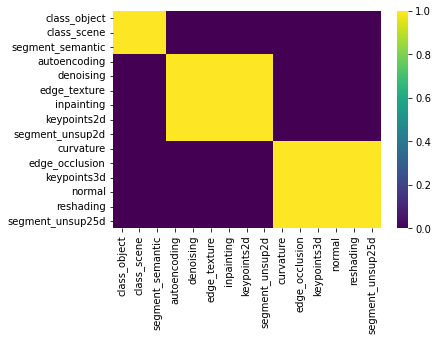

In [12]:
# model RDM
model_rdm = pd.DataFrame(
    np.full((len(NETS_ALL), len(NETS_ALL)), np.nan), columns=NETS_ALL, index=NETS_ALL
)

for combi in combinations_with_replacement(NETS_ALL, 2):
    if (
        combi in combinations_with_replacement(NETS_SEMANTIC, 2)
        or combi in combinations_with_replacement(NETS_2D, 2)
        or combi in combinations_with_replacement(NETS_3D, 2)
    ):
        model_rdm.loc[combi] = 1
        model_rdm.loc[tuple(reversed(combi))] = 1
    else:
        model_rdm.loc[combi] = 0
        model_rdm.loc[tuple(reversed(combi))] = 0
sns.heatmap(model_rdm, cmap="viridis")


In [10]:
model_rdm.to_hdf(os.path.join(PATH_RESULTS, "sem_2d_3d","predictor1 sem2d3dnets.hd5"), key="predictor_rdm1")

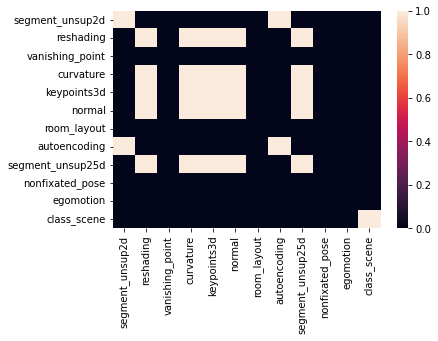

In [13]:
# Extend model rdm to contain all models to use as predictor. Fill values for models not belonging to any class with zeros.
predictor_rdm_1 = pd.DataFrame(0, index=_models, columns=_models)
for c1, c2 in combinations_with_replacement(_models, 2):
    if c1 in model_rdm.index and c2 in model_rdm.index:
        predictor_rdm_1.loc[c1, c2] = model_rdm.loc[c1, c2]
        predictor_rdm_1.loc[c2, c1] = model_rdm.loc[c2, c1]
    else:
        predictor_rdm_1.loc[c1, c2] = 0
        predictor_rdm_1.loc[c2, c1] = 0
sns.heatmap(predictor_rdm_1)

In [11]:
predictor_rdm_1.to_hdf(os.path.join(PATH_RESULTS, "sem_2d_3d","predictor1 allnets.hd5"), key="predictor_rdm_1")

# correlate integration ranking across scales, studies

In [25]:
factor1_rdms = (
    dfi.unstack("model").groupby(["layer", "dataset", "scale"]).apply(calculate_rdm)
)

In [26]:
# factor1_rdms.to_hdf(os.path.join(PATH_RESULTS, "sem_2d_3d", "all.h5"), key="factor1_rdms")
# factor1_rdms.to_hdf(os.path.join(PATH_RESULTS, "sem_2d_3d", "sem2d3d_nets.h5"), key="factor1_rdms")
# factor1_rdms.to_hdf(os.path.join(PATH_RESULTS, "sem_2d_3d", "sem2d3d_nets_averaged.h5"), key="factor1_rdms")
# factor1_rdms.to_hdf(os.path.join(PATH_RESULTS, "sem_2d_3d", "sem2d3d_nets_maxpool.h5"), key="factor1_rdms")
factor1_rdms.to_hdf(os.path.join(PATH_RESULTS, "sem_2d_3d", "top12nets unblocked.h5"), key="factor1_rdms")

In [ ]:
factor1_rdms = pd.read_hdf(
    os.path.join(PATH_RESULTS, "sem_2d_3d", "all_unblocked.h5"), key="factor1_rdms"
)

/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/pandas/io/pytables.py:3007: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = factory(


In [ ]:
factor1_rdms = pd.read_hdf(
    os.path.join(PATH_RESULTS, "sem_2d_3d", "sem2d3d_nets_unblocked.h5"), key="factor1_rdms"
)

In [ ]:
factor1_rdms = pd.read_hdf(
    os.path.join(PATH_RESULTS, "sem_2d_3d", "sem2d3d_nets_maxpool.h5"), key="factor1_rdms"
)

In [ ]:
factor1_rdms = pd.read_hdf(
    os.path.join(PATH_RESULTS, "sem_2d_3d", "sem2d3d_nets_averaged.h5"), key="factor1_rdms"
)

In [27]:
correlations_with_model = (
    factor1_rdms.groupby(["layer", "dataset", "scale"])
    .apply(correlate_rdms, rdm2=predictor_rdm_1, correlation="spearman")
    .to_frame()
)

correlations_with_model = (
    correlations_with_model.assign(
        correlation=correlations_with_model[0].transform(lambda x: x[0]),
        pvalue=correlations_with_model[0].transform(lambda x: x[1]),
    )
    .drop(0, axis=1)
    .unstack("layer")
)

dtype_scale = CategoricalDtype(categories=SCALE_NAMES, ordered=True)

correlations_with_model = (
    correlations_with_model.droplevel("scale")
    .assign(
        scale=correlations_with_model.index.get_level_values("scale").astype(
            dtype_scale
        )
    )
    .set_index("scale", append=True)
    .sort_index()
)

In [16]:
def sem2d3d_plot_modelcorr(d):
    ax = d.correlation.T.plot()

    alpha = 0.05
    n_cols = d.correlation.columns.size
    masks = (d.pvalue < (alpha/n_cols)).T #mcc


    for ofs, scale in enumerate(d.index):
        mask = masks[scale].values
        x = np.arange(n_cols).reshape(-1, 1)[mask].squeeze()
        h = np.full(x.shape, d.correlation.max().max()) + 5 * 0.012 - ofs * 0.012 + 0.03
        ax.scatter(x, h)
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

""


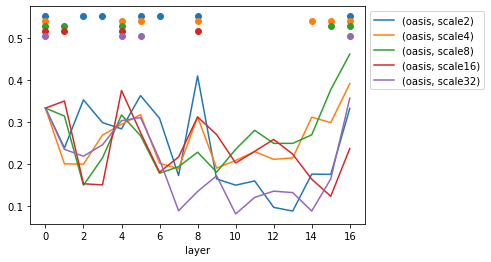

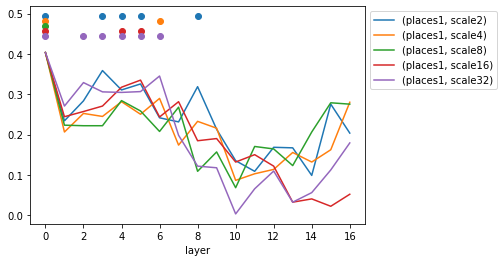

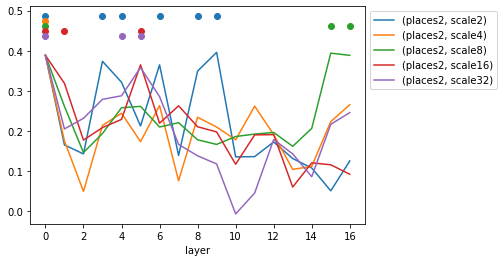

In [ ]:
correlations_with_model.groupby("dataset").apply(sem2d3d_plot_modelcorr)

""


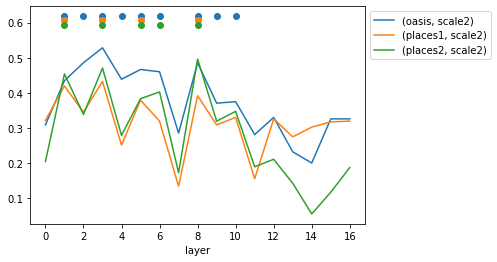

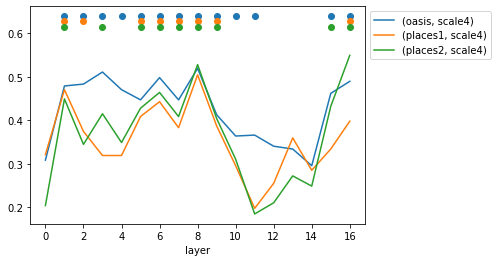

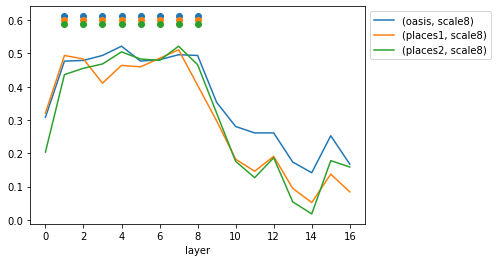

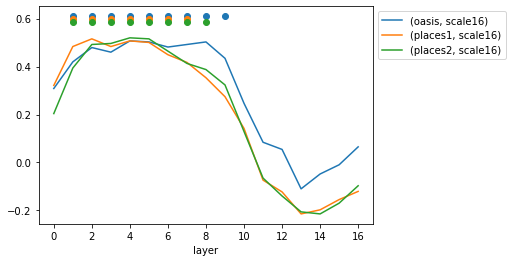

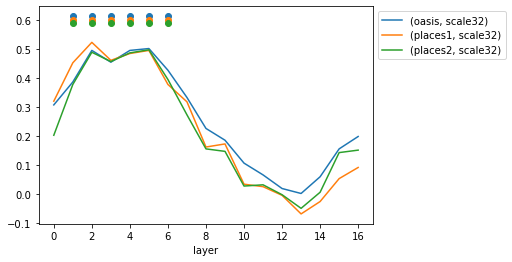

In [17]:
correlations_with_model.groupby("scale").apply(sem2d3d_plot_modelcorr)

""


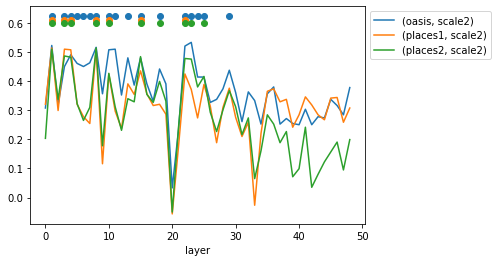

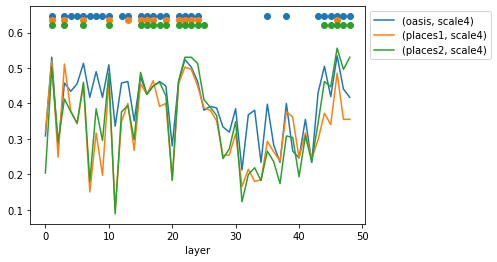

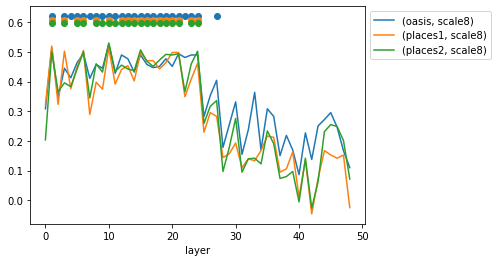

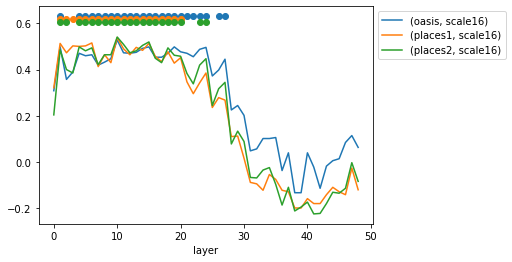

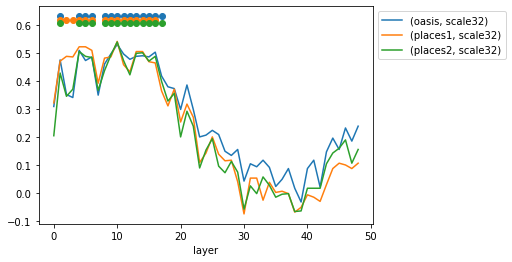

In [28]:
correlations_with_model.groupby("scale").apply(sem2d3d_plot_modelcorr)

#### all nets unblocked

#### sem2d3d nets unblocked

In [ ]:
pl = (
    correlations_with_model.unstack("layer")
    .correlation.groupby("dataset")
    .apply(lambda x: x.T.plot())
)

#### sem2d3d nets average

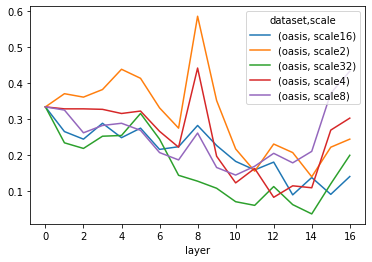

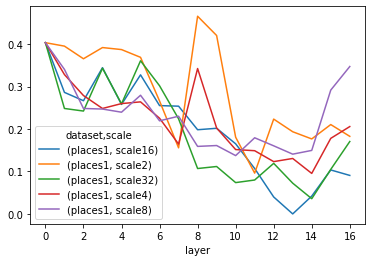

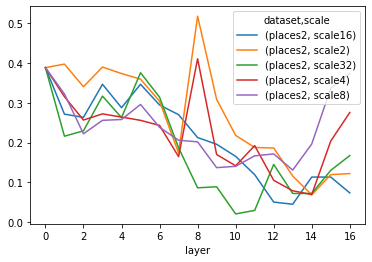

In [ ]:
pl = (
    correlations_with_model.loc[(slice(None), slice(None), slice(None))]
    .unstack("layer")
    .correlation.groupby("dataset")
    .apply(lambda x: x.T.plot(subplots=False))
)

#### sem2d3dnets maxpool

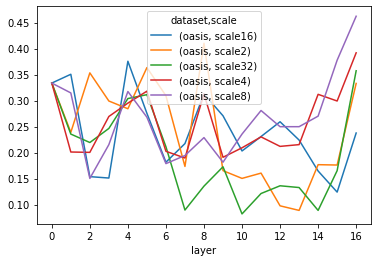

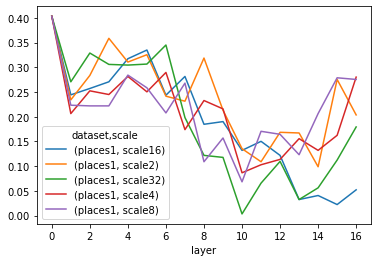

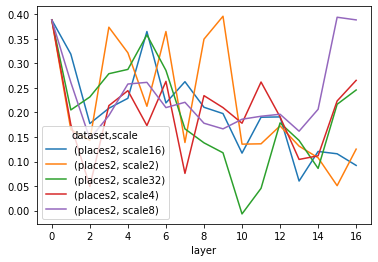

In [ ]:
pl = (
    correlations_with_model.loc[(slice(None), slice(None), slice(None))]
    .unstack("layer")
    .correlation.groupby("dataset")
    .apply(lambda x: x.T.plot(subplots=False))
)

# prediction from averaged integration

## plot function

In [152]:
def plot_ibcorr_from_avg_int(dfi_plot, dfibc_plot, ratings):
    # per class best and worst prediction from individual nets
    Y1 = dfibc_plot.groupby(["layer", "class"]).agg([min, max])
    Y2 = (
        dfi_plot.groupby(["class", "layer", "img"])
        .mean()
        .groupby(["layer", "class"])
        .aggregate(lambda i: spearmanr(i, ratings)[0])
        .unstack("class")
    )

    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

    modelclass = "semantic"
    ax = axes[0]
    ax.fill_between(
        Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
        Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
        Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
    )
    ax.plot(Y2.loc[:, (slice(None), modelclass)], c="red")
    ax.set_title(modelclass)

    modelclass = "2d"
    ax=axes[1]
    ax.fill_between(
        Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
        Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
        Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
    )
    ax.plot(Y2.loc[:, (slice(None), modelclass)], c="red")
    ax.set_title(modelclass)

    modelclass = "3d"
    ax=axes[2]
    ax.fill_between(
        Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
        Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
        Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
        label="min-max ibcorr from nets"
    )
    ax.plot(Y2.loc[:, (slice(None), modelclass)], c="red", label="ibcorr from avg.\n integration")
    ax.set_title(modelclass)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right',bbox_to_anchor=(1.2,.5))
    fig.tight_layout()

##

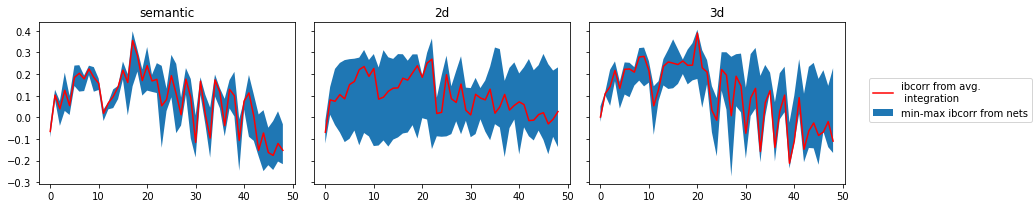

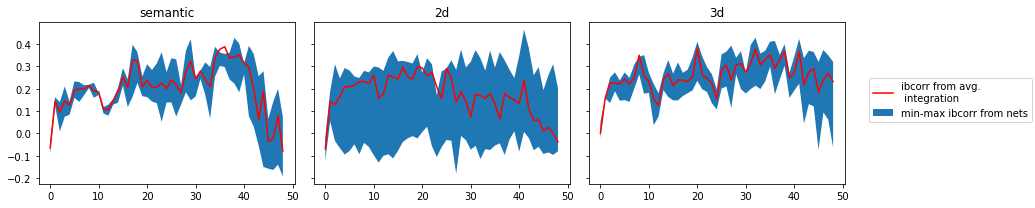

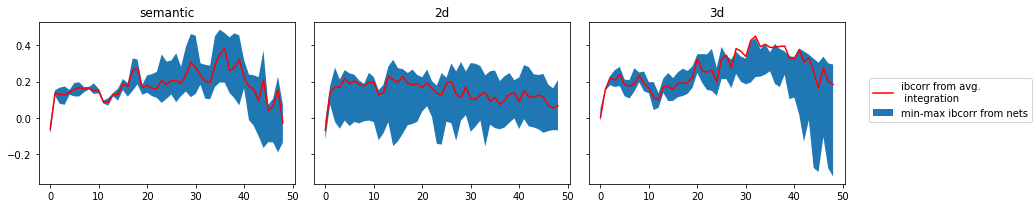

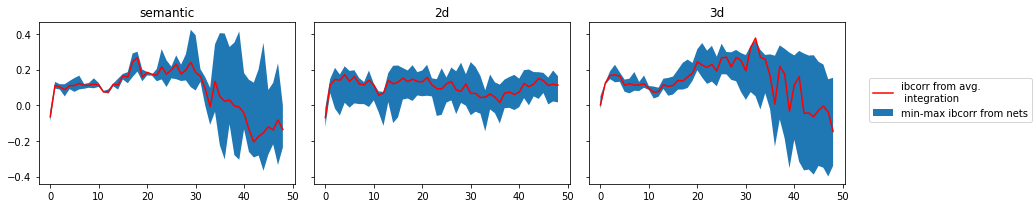

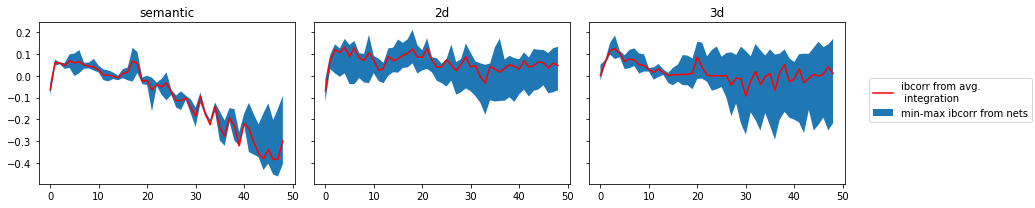

In [153]:
st = "short presentation"
da = "places1"

sc = "scale2"
plot_ibcorr_from_avg_int(dfi.loc[(da, sc)], dfibc.loc[(st, sc)], studyratings(st))

sc = "scale4"
plot_ibcorr_from_avg_int(dfi.loc[(da, sc)], dfibc.loc[(st, sc)], studyratings(st))

sc = "scale8"
plot_ibcorr_from_avg_int(dfi.loc[(da, sc)], dfibc.loc[(st, sc)], studyratings(st))

sc = "scale16"
plot_ibcorr_from_avg_int(dfi.loc[(da, sc)], dfibc.loc[(st, sc)], studyratings(st))

sc = "scale32"
plot_ibcorr_from_avg_int(dfi.loc[(da, sc)], dfibc.loc[(st, sc)], studyratings(st))

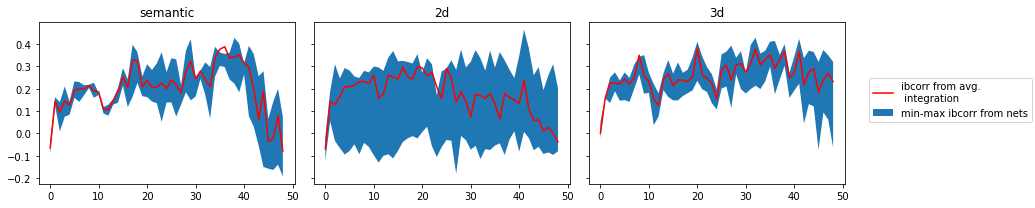

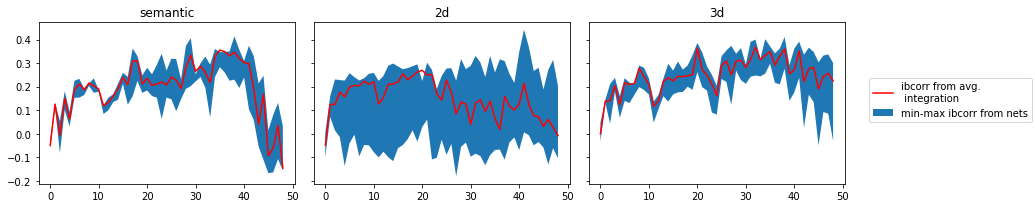

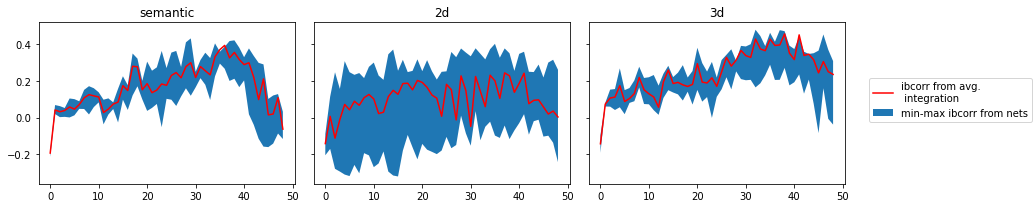

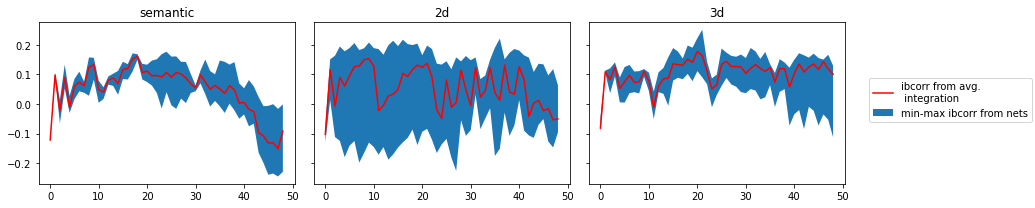

In [154]:
sc = "scale4"
st = "short presentation"
da = studyname2datasetname(st)

st = "short presentation"
da = studyname2datasetname(st)
plot_ibcorr_from_avg_int(dfi.loc[(da, sc)], dfibc.loc[(st, sc)], studyratings(st))

st = "long presentation"
da = studyname2datasetname(st)
plot_ibcorr_from_avg_int(dfi.loc[(da, sc)], dfibc.loc[(st, sc)], studyratings(st))

st = "complexity order"
da = studyname2datasetname(st)
plot_ibcorr_from_avg_int(dfi.loc[(da, sc)], dfibc.loc[(st, sc)], studyratings(st))

st = "oasis"
da = studyname2datasetname(st)
plot_ibcorr_from_avg_int(dfi.loc[(da, sc)], dfibc.loc[(st, sc)], studyratings(st))

# class average integration

In [8]:
dfi

integration
dataset scale   class    model            layer img             
oasis   scale16 2d       autoencoding     0     0      -0.999972
                                                1      -0.999983
                                                2      -0.999993
                                                3      -0.999988
                                                4      -0.999971
...                                                          ...
places2 scale8  semantic segment_semantic 48    245    -0.189702
                                                246    -0.229988
                                                247    -0.730587
                                                248    -0.266785
                                                249    -0.445387

[5144995 rows x 1 columns]

In [9]:
dfi_plot = dfi.loc[("places1","scale4")]
dfibc_plot = dfibc.loc[("short presentation","scale4")]

In [10]:
# min, max, avg integration from classes
Y1 = dfi_plot.groupby(["layer", "class","model"]).mean().groupby(["layer", "class"]).agg([min, max])
Y2 = dfi_plot.groupby(["layer", "class"]).mean().unstack("class")

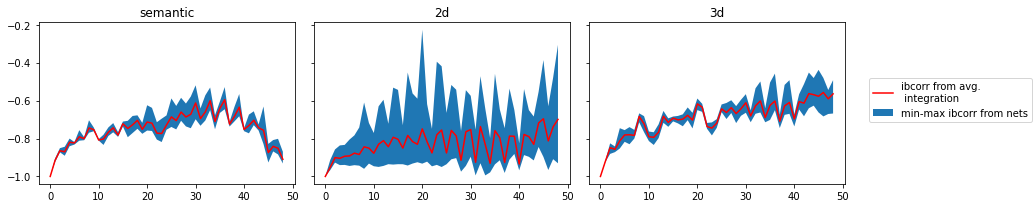

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

modelclass = "semantic"
ax = axes[0]
ax.fill_between(
    Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
    Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
    Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
)
ax.plot(Y2.loc[:, (slice(None), modelclass)], c="red")
ax.set_title(modelclass)

modelclass = "2d"
ax=axes[1]
ax.fill_between(
    Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
    Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
    Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
)
ax.plot(Y2.loc[:, (slice(None), modelclass)], c="red")
ax.set_title(modelclass)

modelclass = "3d"
ax=axes[2]
ax.fill_between(
    Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
    Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
    Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
    label="min-max ibcorr from nets"
)
ax.plot(Y2.loc[:, (slice(None), modelclass)], c="red", label="ibcorr from avg.\n integration")
ax.set_title(modelclass)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right',bbox_to_anchor=(1.2,.5))
fig.tight_layout()

# class average ibcorr seperateplots

In [27]:
dfi_plot = dfi.loc[("places1","scale4")]
dfibc_plot = dfibc.loc[("short presentation","scale4")]

## plot function

In [16]:
def plot_min_max_mean(dfibc_plot):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

    # min, max, avg integration from classes
    Y1 = dfibc_plot.groupby(["layer", "class"]).agg([min, max])
    Y2 = dfibc_plot.groupby(["layer", "class"]).mean().unstack("class")

    modelclass = "semantic"
    ax = axes[0]
    ax.fill_between(
        Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
        Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
        Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
    )
    ax.plot(Y2.loc[:, (slice(None), modelclass)], c="red")
    ax.set_title(modelclass)

    modelclass = "2d"
    ax=axes[1]
    ax.fill_between(
        Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
        Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
        Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
    )
    ax.plot(Y2.loc[:, (slice(None), modelclass)], c="red")
    ax.set_title(modelclass)

    modelclass = "3d"
    ax=axes[2]
    ax.fill_between(
        Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
        Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
        Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
        label="min-max ibcorr from nets"
    )
    ax.plot(Y2.loc[:, (slice(None), modelclass)], c="red", label="ibcorr from avg.\n integration")
    ax.set_title(modelclass)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right',bbox_to_anchor=(1.2,.5))
    fig.tight_layout()

##

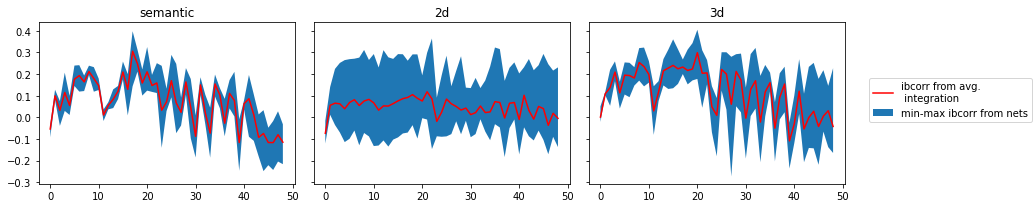

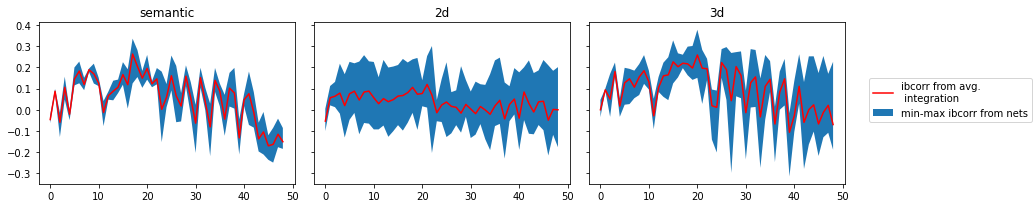

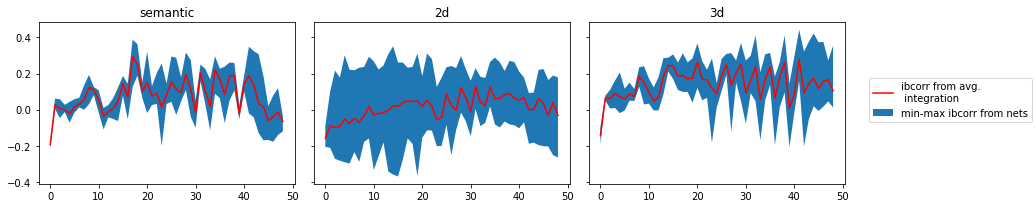

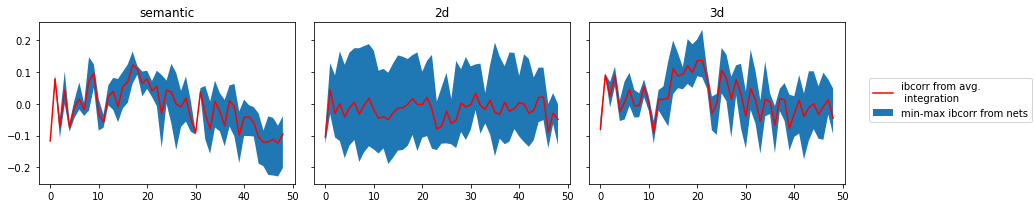

In [19]:
sc = "scale2"

st = studyname("study1")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study2")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study3")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study4")
plot_min_max_mean(dfibc.loc[(st, sc)])

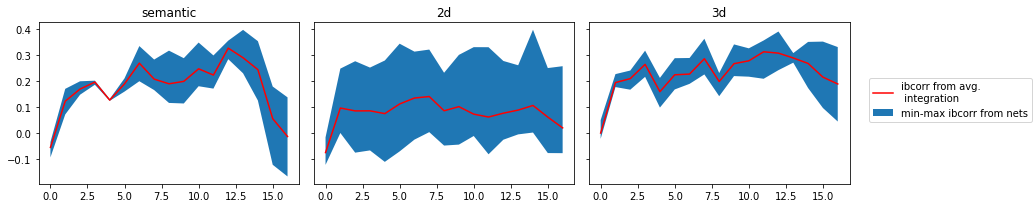

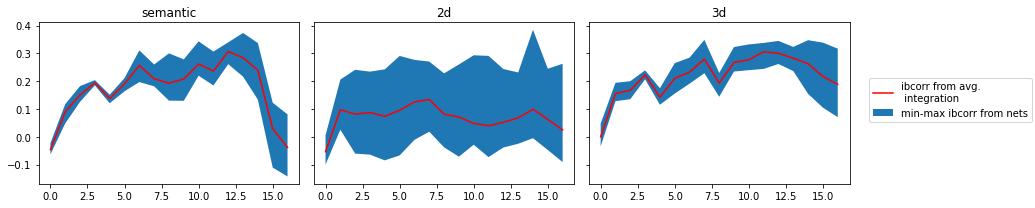

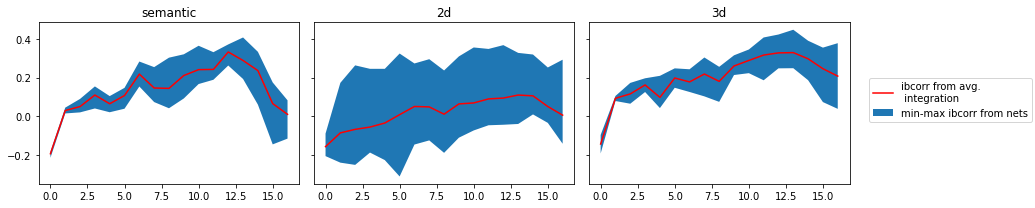

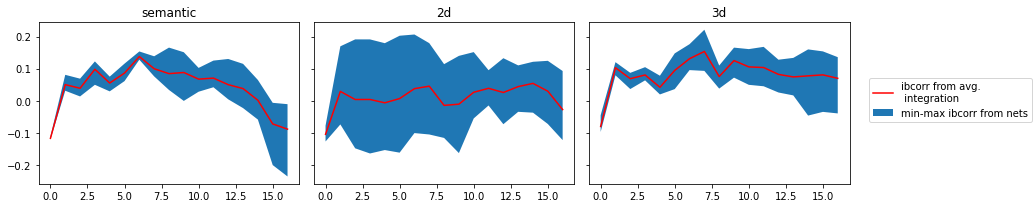

In [28]:
sc = "scale4"

st = studyname("study1")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study2")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study3")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study4")
plot_min_max_mean(dfibc.loc[(st, sc)])

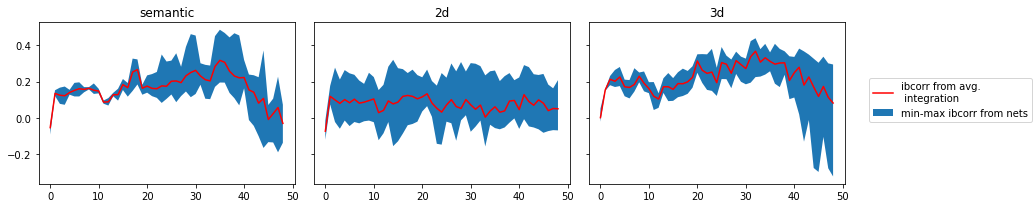

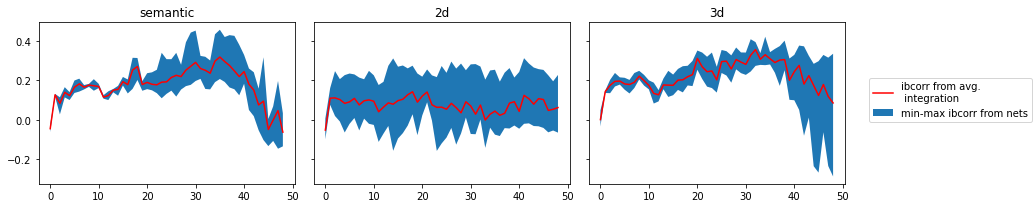

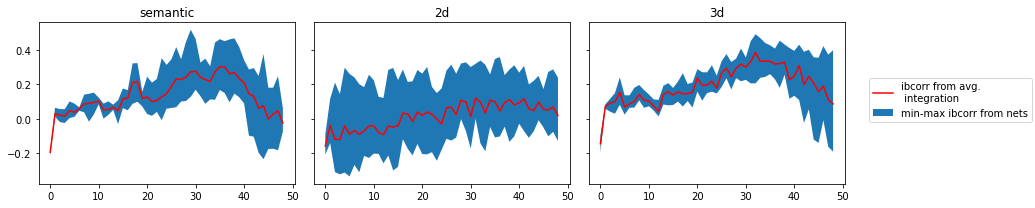

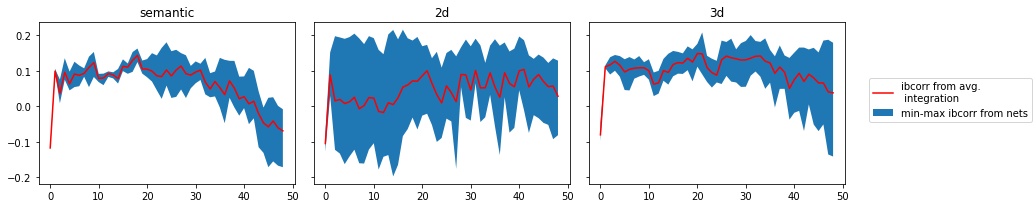

In [20]:
sc = "scale8"

st = studyname("study1")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study2")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study3")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study4")
plot_min_max_mean(dfibc.loc[(st, sc)])

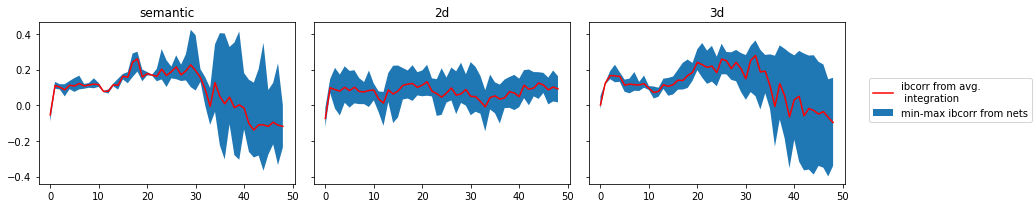

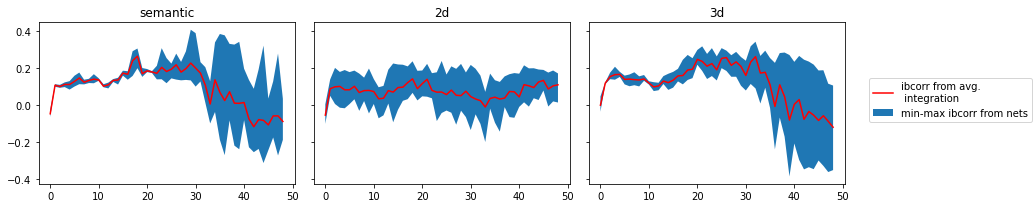

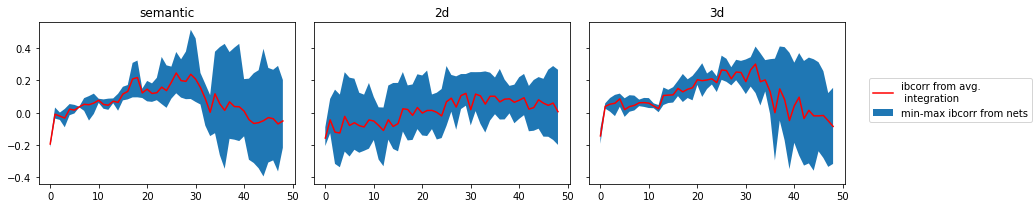

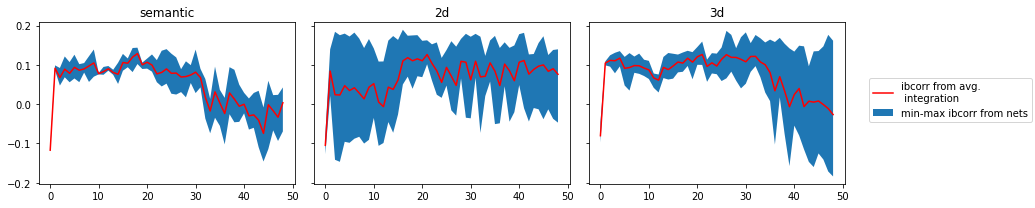

In [21]:
sc = "scale16"

st = studyname("study1")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study2")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study3")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study4")
plot_min_max_mean(dfibc.loc[(st, sc)])

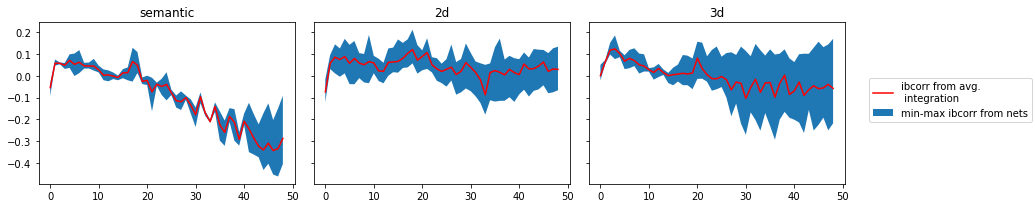

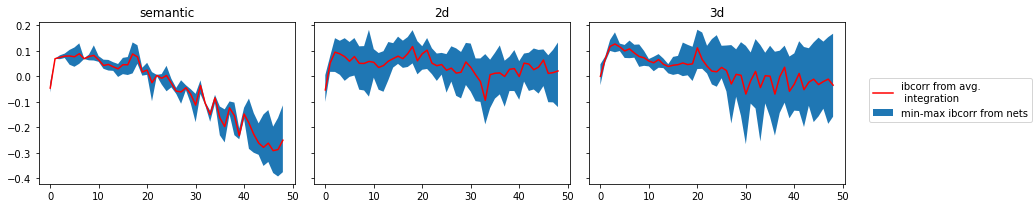

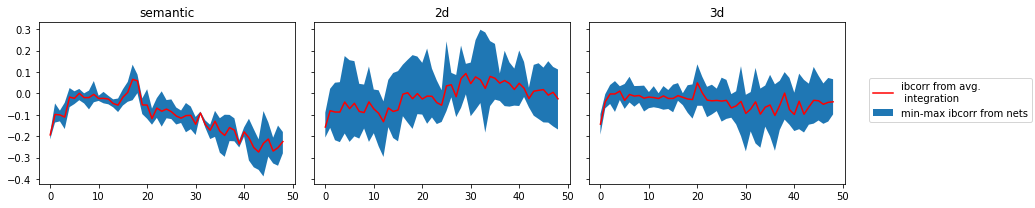

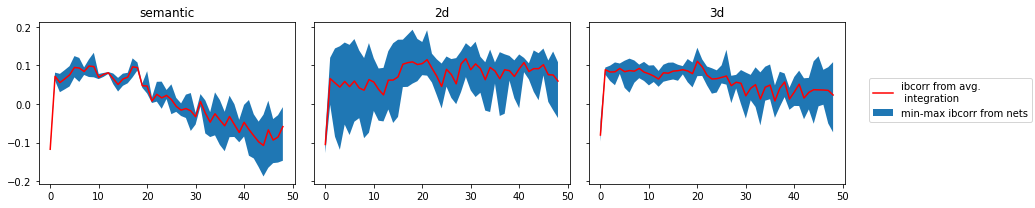

In [22]:
sc = "scale32"

st = studyname("study1")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study2")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study3")
plot_min_max_mean(dfibc.loc[(st, sc)])

st = studyname("study4")
plot_min_max_mean(dfibc.loc[(st, sc)])

# class average ibcorr studies scales

In [ ]:
# lineplots of ibcorr
# studies in columns, scales in rows

In [31]:
dfibc

ibcorr
study              scale   class    model            layer          
complexity order   scale16 2d       autoencoding     0     -0.197509
                                                     1     -0.093092
                                                     2     -0.266074
                                                     3     -0.275694
                                                     4     -0.035985
...                                                              ...
short presentation scale8  semantic segment_semantic 44     0.371683
                                                     45     0.071026
                                                     46     0.106000
                                                     47     0.226946
                                                     48    -0.026642

[14700 rows x 1 columns]

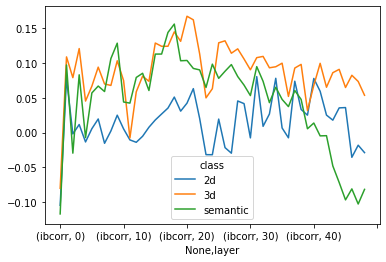

In [37]:
dfibc.loc[("oasis", "scale4")].unstack("layer").groupby("class").mean().T.plot()

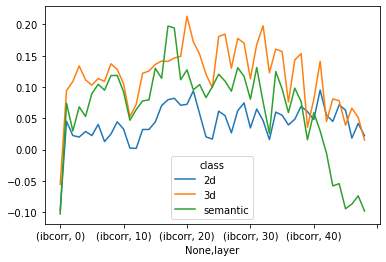

In [29]:
dfibc.unstack("layer").groupby("class").mean().T.plot()

# processing steps variance partitioning

MODEL RDM as target,  steps as predictors <br>
shared variance between any of the models, subsequent added explained variance by each of the steps

In [ ]:
# get beauty predictions for images from best predicting model in each layer for each class
bestnets = (
    dfibc_m.unstack("layer")
    .groupby("class")
    .aggregate(lambda c: c.idxmax()[0])
    .stack("layer")
    .rename({"ibcorr": "net"}, axis=1)
    .reset_index()
    .values.tolist()
)
dfi_m_best = (
    dfi_m.unstack("img")
    .reorder_levels(["class", "layer", "model"])
    .loc[bestnets, :]
    .droplevel("model")
    .stack("img")
    #    .unstack("layer")
)

In [ ]:
ibcorr_from_classmaxpool = (
    dfi_m_best.groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classmaxpool.plot()

In [ ]:
# average beauty prediction (i.e. integration) for each image from each class
# since the ib-correlation is the spearman correlation. Just do OLS variance partitioning for now an then talk to daniel about it.
ibcorr_from_classmaxpool = (
    dfi_m_best.groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classmaxpool.plot()

ibcorr_from_classavg = (
    dfi_m.groupby(["class", "layer", "img"])
    .mean()
    .groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classavg.plot()

In [ ]:
dfi_m_classavg = dfi_m.groupby(["class", "layer", "img"]).mean().unstack("class")
dfi_m_classavg

In [ ]:
r2_all = dfi_m_classavg.groupby(["layer"]).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

In [ ]:
r2_semantic = r2_all - dfi_m_classavg.loc[:, (slice(None), ["2d", "3d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

r2_2d = r2_all - dfi_m_classavg.loc[:, (slice(None), ["semantic", "3d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)


r2_3d = r2_all - dfi_m_classavg.loc[:, (slice(None), ["semantic", "2d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

In [ ]:
plt.plot(r2_3d, label="3d")
plt.plot(r2_2d, label="2d")
plt.plot(r2_semantic, label="semantic")
plt.legend()

In [ ]:
# create linear model
# single study & layer
dataset = "places1"
layer_idx = 48

df_icr.loc[dataset, layer_idx]

OLS(Y, X).fit().rsquared

In [ ]:
def do_variance_partitioning():
    # do variance partitioning for one layer
    # i.e. for all unique, shared and full combinations of the three predictors
    # return dataframe with all R2 values
    pass

### semantic, 2d, 3d along layers

In [ ]:
# image activations

#### raw integration amount


In [ ]:
# get beauty predictions for images from best predicting model in each layer for each class
bestnets = (
    dfibc_m.unstack("layer")
    .groupby("class")
    .aggregate(lambda c: c.idxmax()[0])
    .stack("layer")
    .rename({"ibcorr": "net"}, axis=1)
    .reset_index()
    .values.tolist()
)
dfi_m_best = (
    dfi_m.unstack("img")
    .reorder_levels(["class", "layer", "model"])
    .loc[bestnets, :]
    .droplevel("model")
    .stack("img")
    #    .unstack("layer")
)

In [ ]:
ibcorr_from_classmaxpool = (
    dfi_m_best.groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classmaxpool.plot()

In [ ]:
# average beauty prediction (i.e. integration) for each image from each class
# since the ib-correlation is the spearman correlation. Just do OLS variance partitioning for now an then talk to daniel about it.
ibcorr_from_classmaxpool = (
    dfi_m_best.groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classmaxpool.plot()

ibcorr_from_classavg = (
    dfi_m.groupby(["class", "layer", "img"])
    .mean()
    .groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classavg.plot()

In [ ]:
dfi_m_classavg = dfi_m.groupby(["class", "layer", "img"]).mean().unstack("class")
dfi_m_classavg

In [ ]:
r2_all = dfi_m_classavg.groupby(["layer"]).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

In [ ]:
r2_semantic = r2_all - dfi_m_classavg.loc[:, (slice(None), ["2d", "3d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

r2_2d = r2_all - dfi_m_classavg.loc[:, (slice(None), ["semantic", "3d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)


r2_3d = r2_all - dfi_m_classavg.loc[:, (slice(None), ["semantic", "2d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

In [ ]:
plt.plot(r2_3d, label="3d")
plt.plot(r2_2d, label="2d")
plt.plot(r2_semantic, label="semantic")
plt.legend()

In [ ]:
# create linear model
# single study & layer
dataset = "places1"
layer_idx = 48

df_icr.loc[dataset, layer_idx]

OLS(Y, X).fit().rsquared

#### raw integration amount


In [ ]:
# average integration of layers
df_int_netavg = df1.groupby("model").mean().transpose()
handles, labels = df_int_netavg.plot().get_legend_handles_labels()

# already order legend by classes
order = [labels.index(netname) for netname in NETS_ALL]
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    loc="center right",
    bbox_to_anchor=(1.5, 0.5),
)

In [ ]:
# average integration, grouped by semantic-2d-3d
colors = (
    len(NETS_SEMANTIC) * ["green"]
    + len(NETS_2D) * ["purple"]
    + len(NETS_3D) * ["orange"]
)

for (netname, int_netavg), color in zip(df_int_netavg.iloc[:, order].items(), colors):
    if netname in NETS_SEMANTIC:
        alpha = 0.7
    else:
        alpha = 0.3
    plt.plot(int_netavg, label=netname, color=color, alpha=alpha)
    plt.legend(loc="center right", bbox_to_anchor=(1.5, 0.5))

#### dev: single layer

In [ ]:
layer_id = 48

# fitler relevant data
layer_df = pd.DataFrame(df.loc[NETS_ALL, "places1", "scale8"][layer_id]).reset_index()
# needed for pivot into wide format
layer_df["img_id"] = layer_df.groupby("model").cumcount()

# pivot
layer_df = layer_df.pivot(columns="model", index="img_id", values=layer_id)

# reorder columns according to semantic-2D-3D nets
layer_df = layer_df[NETS_ALL]

rdm = calculate_rdm(layer_df, correlation_type="spearman")

pearsonr(rdm.values.flatten(), model_rdm.values.flatten())

In [ ]:
pearsonr(rdm.values.flatten(), model_rdm.values.flatten())

In [ ]:
sns.heatmap(rdm, cmap="viridis")

In [ ]:
xdm = rdm[rdm > 0.142].fillna(0)
sns.heatmap(xdm, cmap="viridis")

In [ ]:
xdm = rdm[rdm < 0].fillna(0)
sns.heatmap(xdm, cmap="viridis")

#### all layers

In [ ]:
model_correlations = []
model_pvalues = []
# iterate layers
for layer_name, layer_series in df.loc[:, "places1", "scale8"].items():

    # put data back into DataFrame
    layer_df = pd.DataFrame(layer_series).reset_index()

    # needed for pivot into wide format
    layer_df["img_id"] = layer_df.groupby("model").cumcount()

    # pivot
    layer_df = layer_df.pivot(columns="model", index="img_id", values=layer_name)

    # reorder columns according to semantic-2D-3D nets
    layer_df = layer_df[NETS_ALL]

    rdm = calculate_rdm(layer_df, correlation_type="spearman")

    model_correlations.append(
        pearsonr(rdm.values.flatten(), model_rdm.values.flatten())[0]
    )
    model_pvalues.append(pearsonr(rdm.values.flatten(), model_rdm.values.flatten())[1])

In [ ]:
alpha = 0.05

sns.lineplot(data=model_correlations)
plt.suptitle("Similarity in what is integrated")
plt.title("Correlation of taskonomy RDM with model (semantic-2D-3D) RDM")
plt.xlabel("Layer")
plt.ylabel("pearson correlation")


for x, layer_pvalue in enumerate(model_pvalues):
    if layer_pvalue < alpha:
        plt.scatter(x, 0, color="cyan", s=100, marker="o")

In [ ]:
# raw ibcorr differences